In [2]:
import os
import pickle
import math
import numpy as np
import cv2
import mediapipe as mp
import torch
import torch.nn as nn

MODELS_DIR = "models"
MODEL_PATH = os.path.join(MODELS_DIR, "yoga_angle_resnet.pt")
META_PATH  = os.path.join(MODELS_DIR, "yoga_angle_resnet_meta.pkl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

with open(META_PATH, "rb") as f:
    meta = pickle.load(f)

class_names = meta["class_names"]
feature_cols = meta["feature_cols"]
angle_stats = meta["angle_stats"]
hidden_dim = meta.get("hidden_dim", 256)

print("Classes:", class_names)
print("Num features:", len(feature_cols))

Using device: cuda
Classes: ['Downdog', 'Goddess', 'Plank', 'Tree', 'Warrior2']
Num features: 12


In [3]:
# load model
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
        )
        self.act = nn.ReLU()

    def forward(self, x):
        out = self.net(x)
        out = out + x
        out = self.act(out)
        return out


class AngleResNet(nn.Module):
    def __init__(self, in_dim, num_classes, hidden_dim=256, num_blocks=3, dropout=0.5):
        super().__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
        )
        self.blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim, dropout=dropout)
            for _ in range(num_blocks)
        ])
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, num_classes)
        )

    def forward(self, x):
        h = self.input_layer(x)
        h = self.blocks(h)
        logits = self.head(h)
        return logits

in_dim = len(feature_cols)
num_classes = len(class_names)
model = AngleResNet(in_dim, num_classes, hidden_dim=hidden_dim, num_blocks=3, dropout=0.5).to(device)

state = torch.load(MODEL_PATH, map_location=device)
model.load_state_dict(state)
model.eval()
print("Model loaded.")

Model loaded.


C:\Users\sandy\AppData\Local\Temp\ipykernel_13668\3584430272.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(MODEL_PATH, map_location=device)


In [4]:
mp_pose = mp.solutions.pose

def calculate_angle(landmark1, landmark2, landmark3):
    x1, y1, _ = landmark1
    x2, y2, _ = landmark2
    x3, y3, _ = landmark3

    angle = math.degrees(
        math.atan2(y3 - y2, x3 - x2) -
        math.atan2(y1 - y2, x1 - x2)
    )
    if angle < 0:
        angle += 360
    return angle


def angles_finder(landmarks):
    P = mp_pose.PoseLandmark

    left_elbow_angle = calculate_angle(
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.LEFT_ELBOW.value],
        landmarks[P.LEFT_WRIST.value]
    )
    right_elbow_angle = calculate_angle(
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_ELBOW.value],
        landmarks[P.RIGHT_WRIST.value]
    )

    left_shoulder_angle = calculate_angle(
        landmarks[P.LEFT_ELBOW.value],
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.LEFT_HIP.value]
    )
    right_shoulder_angle = calculate_angle(
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_ELBOW.value]
    )

    left_knee_angle = calculate_angle(
        landmarks[P.LEFT_HIP.value],
        landmarks[P.LEFT_KNEE.value],
        landmarks[P.LEFT_ANKLE.value]
    )
    right_knee_angle = calculate_angle(
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_KNEE.value],
        landmarks[P.RIGHT_ANKLE.value]
    )

    hand_angle = calculate_angle(
        landmarks[P.LEFT_ELBOW.value],
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_ELBOW.value]
    )

    left_hip_angle = calculate_angle(
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.LEFT_HIP.value],
        landmarks[P.LEFT_KNEE.value]
    )
    right_hip_angle = calculate_angle(
        landmarks[P.RIGHT_SHOULDER.value],
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_KNEE.value]
    )

    neck_angle_uk = calculate_angle(
        landmarks[P.NOSE.value],
        landmarks[P.LEFT_SHOULDER.value],
        landmarks[P.RIGHT_SHOULDER.value]
    )

    left_wrist_angle_bk = calculate_angle(
        landmarks[P.LEFT_WRIST.value],
        landmarks[P.LEFT_HIP.value],
        landmarks[P.LEFT_ANKLE.value]
    )
    right_wrist_angle_bk = calculate_angle(
        landmarks[P.RIGHT_WRIST.value],
        landmarks[P.RIGHT_HIP.value],
        landmarks[P.RIGHT_ANKLE.value]
    )

    return {
        "left_elbow_angle": left_elbow_angle,
        "right_elbow_angle": right_elbow_angle,
        "left_shoulder_angle": left_shoulder_angle,
        "right_shoulder_angle": right_shoulder_angle,
        "left_knee_angle": left_knee_angle,
        "right_knee_angle": right_knee_angle,
        "hand_angle": hand_angle,
        "left_hip_angle": left_hip_angle,
        "right_hip_angle": right_hip_angle,
        "neck_angle_uk": neck_angle_uk,
        "left_wrist_angle_bk": left_wrist_angle_bk,
        "right_wrist_angle_bk": right_wrist_angle_bk,
    }

In [5]:
def landmarks_from_image(image_bgr):
    mp_drawing = mp.solutions.drawing_utils
    with mp_pose.Pose(
        static_image_mode=True,
        model_complexity=2,
        enable_segmentation=False,
        min_detection_confidence=0.5
    ) as pose:

        image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
        results = pose.process(image_rgb)

        if not results.pose_landmarks:
            return None, None

        h, w, _ = image_bgr.shape
        landmarks = []
        for lm in results.pose_landmarks.landmark:
            landmarks.append((int(lm.x * w), int(lm.y * h), lm.z * w))

        # create an annotated image for display
        out_img = image_bgr.copy()
        mp_drawing.draw_landmarks(
            image=out_img,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS
        )

        return out_img, landmarks

In [6]:
POSE_ANGLE_WHITELIST = {
    "downdog": [
        "left_shoulder_angle", "right_shoulder_angle",
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_wrist_angle_bk", "right_wrist_angle_bk",
        "neck_angle_uk",
    ],
    "plank": [
        "left_shoulder_angle", "right_shoulder_angle",
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_elbow_angle", "right_elbow_angle",
        "neck_angle_uk",
    ],
    "goddess": [
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_shoulder_angle", "right_shoulder_angle",
    ],
    "tree": [
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_shoulder_angle", "right_shoulder_angle",
    ],
    "warrior2": [
        "left_hip_angle", "right_hip_angle",
        "left_knee_angle", "right_knee_angle",
        "left_shoulder_angle", "right_shoulder_angle",
        "hand_angle",
    ],
}

def circular_diff(a, b):
    """
    difference between two angles in degrees, result is in [-180, 180].
    """
    return (a - b + 180) % 360 - 180

In [7]:
def describe_angle_feedback(pose, angle_name, diff, side):
    """
    turn an angle deviation into a human-readable coaching tip.
    """
    more = diff > 0  # angle larger than typical
    side_word = f"{side} " if side else ""

    def hips_too_high_low():
        if more:
            return f"Lower your {side_word}hip slightly; it's higher than the usual alignment."
        else:
            return f"Lift your {side_word}hip a bit; it's lower than the usual alignment."

    def knee_straight_vs_soft():
        if more:
            return f"Straighten your {side_word}knee a bit more."
        else:
            return f"Slightly soften your {side_word}knee instead of locking it."

    def shoulder_open_vs_stack():
        if more:
            return f"Push the floor away and open your {side_word}shoulder a bit more."
        else:
            return f"Stack your {side_word}shoulder more strongly; don't let it collapse."

    def wrist_line_feedback():
        if more:
            return f"Bring your {side_word}arm closer to a straight line from shoulder to wrist."
        else:
            return f"Relax your {side_word}arm a bit; it's straighter than typical."

    def neck_feedback():
        if more:
            return "Lengthen the back of your neck; your head is tipped more than usual."
        else:
            return "Gently relax your neck; you're keeping it more neutral than most samples."

    # pose specific logic
    # Downdog & Plank
    if pose in ["downdog", "plank"]:
        if "hip_angle" in angle_name:
            return hips_too_high_low()
        if "knee_angle" in angle_name:
            return knee_straight_vs_soft()
        if "shoulder_angle" in angle_name:
            return shoulder_open_vs_stack()
        if "wrist_angle_bk" in angle_name:
            return wrist_line_feedback()
        if "neck_angle" in angle_name:
            return neck_feedback()

    # Goddess & Warrior2: big bent knees + open hips
    if pose in ["goddess", "warrior2"]:
        if "knee_angle" in angle_name:
            if more:
                return f"Bend your {side_word}knee a bit deeper."
            else:
                return f"Straighten your {side_word}knee just a touch."
        if "hip_angle" in angle_name:
            if more:
                return f"Draw your {side_word}hip slightly under you; it's more open than typical."
            else:
                return f"Open your {side_word}hip slightly more to the side."
        if "shoulder_angle" in angle_name:
            return shoulder_open_vs_stack()
        if "hand_angle" in angle_name:
            if more:
                return "Level your arms; one arm is lifted higher than usual."
            else:
                return "Lift your arms to a level line; they're lower than typical."

    # Tree: balance + standing leg alignment
    if pose == "tree":
        if "knee_angle" in angle_name:
            if more:
                return f"Press your {side_word}knee out a bit more for a wider opening."
            else:
                return f"Keep your {side_word}knee from collapsing inward."
        if "hip_angle" in angle_name:
            if more:
                return f"Square your {side_word}hip a bit more; it's opening more than usual."
            else:
                return f"Open your {side_word}hip slightly to the side."
        if "shoulder_angle" in angle_name:
            return shoulder_open_vs_stack()
        if "neck_angle" in angle_name:
            return neck_feedback()
    
    return None # no cutom rules

In [ ]:
def analyze_image(image_path, std_factor=2.0, min_deg=10.0, show_image=True):
    # run mediapipe
    img = cv2.imread(image_path)
    if img is None:
        print("Could not read image:", image_path)
        return

    out_img, landmarks = landmarks_from_image(img)
    if landmarks is None:
        print("No pose detected.")
        return

    angle_dict = angles_finder(landmarks)

    feats = [angle_dict.get(name, 0.0) for name in feature_cols] # feature vectors
    x = torch.tensor(feats, dtype=torch.float32, device=device).unsqueeze(0)

    # predict
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)[0].cpu().numpy()
        cls_idx = int(np.argmax(probs))
        cls_name = class_names[cls_idx]
        confidence = probs[cls_idx]

    print(f"Predicted pose: {cls_name} (prob={confidence:.3f})")

    # get angle stats
    stats = angle_stats.get(cls_name, None)
    if stats is None:
        print("No angle stats found for this pose (should not happen).")
        return

    mean_angles = np.array(stats["mean"])
    std_angles  = np.array(stats["std"])

    whitelist = POSE_ANGLE_WHITELIST.get(cls_name, feature_cols)

    print(
        "\nFeedback (we flag joints where |diff| > max("
        f"{std_factor}std, {min_deg}°)):"
    )

    any_flag = False

    for name, value, mean, std in zip(feature_cols, feats, mean_angles, std_angles):
        if name not in whitelist:
            continue

        diff = circular_diff(value, mean)
        thresh = max(min_deg, std_factor * std)

        if abs(diff) < thresh:
            continue

        any_flag = True
        side = "left" if "left_" in name else "right" if "right_" in name else ""
        direction = "more" if diff > 0 else "less"

        # coaching tip
        text = describe_angle_feedback(cls_name, name, diff, side)
        if text is None:
            text = (
                f"Your {name.replace('_', ' ')} is about "
                f"{abs(diff):.1f}° {direction} than typical."
            )

        print(
            f"  - {text} "
            f"(your {name} {value:.1f}°, typical {mean:.1f}°; "
            f"≈{abs(diff):.1f}° {direction}, threshold ≈{thresh:.1f}°)"
        )

    if not any_flag:
        print("All checked joint angles look good!")

    if show_image:
        from matplotlib import pyplot as plt
        plt.figure(figsize=(5, 8))
        plt.imshow(cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Predicted: {cls_name}")
        plt.axis("off")
        plt.show()


Predicted pose: Downdog (prob=1.000)

Feedback (we flag joints where |diff| > max(1.0std, 20°)):
  - Your left knee angle is about 27.6° less than typical. (your left_knee_angle 151.6°, typical 179.2°; ≈27.6° less, threshold ≈20.0°)
  - Your right knee angle is about 25.3° less than typical. (your right_knee_angle 154.6°, typical 179.9°; ≈25.3° less, threshold ≈20.0°)
  - Your neck angle uk is about 136.7° less than typical. (your neck_angle_uk 61.5°, typical 198.2°; ≈136.7° less, threshold ≈101.0°)


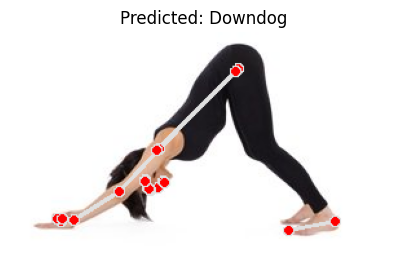

In [10]:
test_image = "test/test3.jpg"
analyze_image(test_image, std_factor=1.0, min_deg=20)